# Exploratory Data Analysis — Heineken Demand Planning

**Objective**: Assess data quality, identify time-series patterns, and propose features relevant to forecasting weekly demand **8 weeks ahead** for beer products across Dutch supermarkets.

**Data**: Daily demand for 3 SKUs × 3 supermarkets (Jan 2019 – Dec 2021) + 15 promotion records.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

SEED = 42
np.random.seed(SEED)
pd.set_option("display.max_columns", 20)

from utils import read_demand, read_promotions, extend_promotions_days, merge, aggregate_to_weekly

In [2]:
demand_raw = read_demand("demand.csv")
promotions = read_promotions("promotions.csv")

print(f"Demand shape: {demand_raw.shape}")
print(f"Date range: {demand_raw.index.min()} to {demand_raw.index.max()}")
print(f"Unique SKUs: {demand_raw['sku'].unique().tolist()}")
print(f"Unique supermarkets: {demand_raw['supermarket'].unique().tolist()}")
print(f"\nPromotions: {promotions.shape[0]} records")
display(demand_raw.head(10))

Demand shape: (9855, 3)
Date range: 2019-01-01 00:00:00 to 2021-12-30 00:00:00
Unique SKUs: ['desperados', 'heineken 0.0', 'heineken regular']
Unique supermarkets: ['albert-heijn', 'jumbo', 'dirk']

Promotions: 15 records


,demand,sku,supermarket
date,,,
2019-01-01,93.0,desperados,albert-heijn
2019-01-02,93.0,desperados,albert-heijn
2019-01-03,94.0,desperados,albert-heijn
2019-01-04,95.0,desperados,albert-heijn
2019-01-05,92.0,desperados,albert-heijn
2019-01-06,87.0,desperados,albert-heijn
2019-01-07,90.0,desperados,albert-heijn
2019-01-08,90.0,desperados,albert-heijn
2019-01-09,92.0,desperados,albert-heijn


## 1. Data Quality Assessment

In [3]:
# Basic statistics
print("=" * 60)
print("BASIC STATISTICS")
print("=" * 60)
display(demand_raw.describe())

print("\nData types:")
print(demand_raw.dtypes)

BASIC STATISTICS


,demand
count,8738.000000
mean,74.240764
std,24.354299
min,10.000000
25%,57.000000
50%,70.000000
75%,93.000000
max,485.000000



Data types:
demand         float64
sku             object
supermarket     object
dtype: object


In [4]:
# Missing values per group
missing = demand_raw.groupby(["sku", "supermarket"])["demand"].agg(
    total="count",
    missing=lambda x: x.isna().sum(),
    pct_missing=lambda x: f"{x.isna().mean() * 100:.1f}%"
)
# Correct total to include NaN rows
group_sizes = demand_raw.groupby(["sku", "supermarket"]).size().rename("total_rows")
missing = missing.join(group_sizes)
missing["pct_missing"] = (missing["missing"] / missing["total_rows"] * 100).round(1).astype(str) + "%"

print("Missing values by SKU-Supermarket group:")
display(missing[["total_rows", "missing", "pct_missing"]])
print(f"\nTotal missing: {demand_raw['demand'].isna().sum()} / {len(demand_raw)} ({demand_raw['demand'].isna().mean()*100:.1f}%)")

Missing values by SKU-Supermarket group:


total_rows  missing pct_missing
sku              supermarket                                  
desperados       albert-heijn        1095      166       15.2%
                 dirk                1095      156       14.2%
                 jumbo               1095       69        6.3%
heineken 0.0     albert-heijn        1095      112       10.2%
                 dirk                1095      110       10.0%
                 jumbo               1095      136       12.4%
heineken regular albert-heijn        1095      115       10.5%
                 dirk                1095      135       12.3%
                 jumbo               1095      118       10.8%


Total missing: 1117 / 9855 (11.3%)


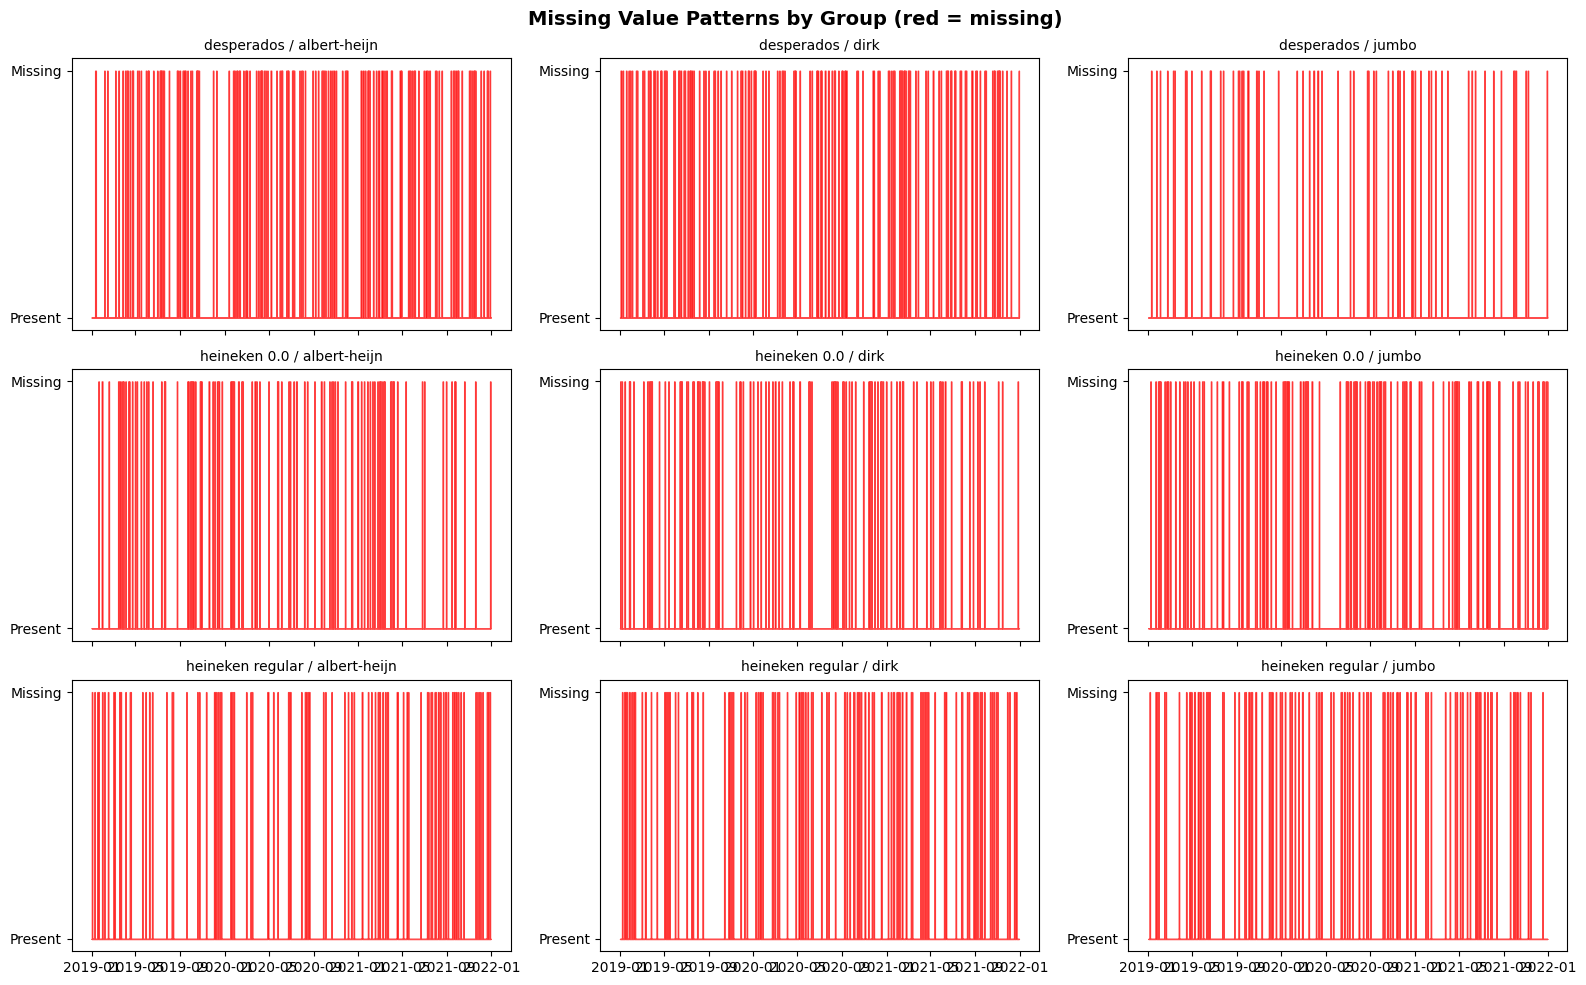

In [5]:
# Visualise missing value patterns
groups = demand_raw.groupby(["sku", "supermarket"])
fig, axes = plt.subplots(3, 3, figsize=(16, 10), sharex=True)

for idx, ((sku, sm), grp) in enumerate(groups):
    ax = axes[idx // 3, idx % 3]
    is_missing = grp["demand"].isna().astype(int)
    ax.fill_between(grp.index, is_missing, alpha=0.7, color="red", step="mid")
    ax.set_title(f"{sku} / {sm}", fontsize=10)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Present", "Missing"])

fig.suptitle("Missing Value Patterns by Group (red = missing)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [6]:
# Check for consecutive missing values (gap lengths)
print("Consecutive missing value gap lengths per group:")
for (sku, sm), grp in groups:
    is_missing = grp["demand"].isna()
    if is_missing.sum() == 0:
        continue
    # Identify consecutive gaps
    gaps = is_missing.ne(is_missing.shift()).cumsum()
    gap_lengths = is_missing.groupby(gaps).sum()
    gap_lengths = gap_lengths[gap_lengths > 0]
    print(f"  {sku}/{sm}: {len(gap_lengths)} gaps, lengths: {sorted(gap_lengths.values, reverse=True)[:10]}")

Consecutive missing value gap lengths per group:
  desperados/albert-heijn: 140 gaps, lengths: [np.int64(4), np.int64(3), np.int64(3), np.int64(3), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2)]
  desperados/dirk: 137 gaps, lengths: [np.int64(4), np.int64(4), np.int64(3), np.int64(3), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2)]
  desperados/jumbo: 64 gaps, lengths: [np.int64(3), np.int64(2), np.int64(2), np.int64(2), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
  heineken 0.0/albert-heijn: 99 gaps, lengths: [np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2)]
  heineken 0.0/dirk: 103 gaps, lengths: [np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(1), np.int64(1), np.int64(1)]
  heineken 0.0/jumbo: 116 gaps, lengths: [np.int64(4), np.int64(3), np.int64(2), np.int

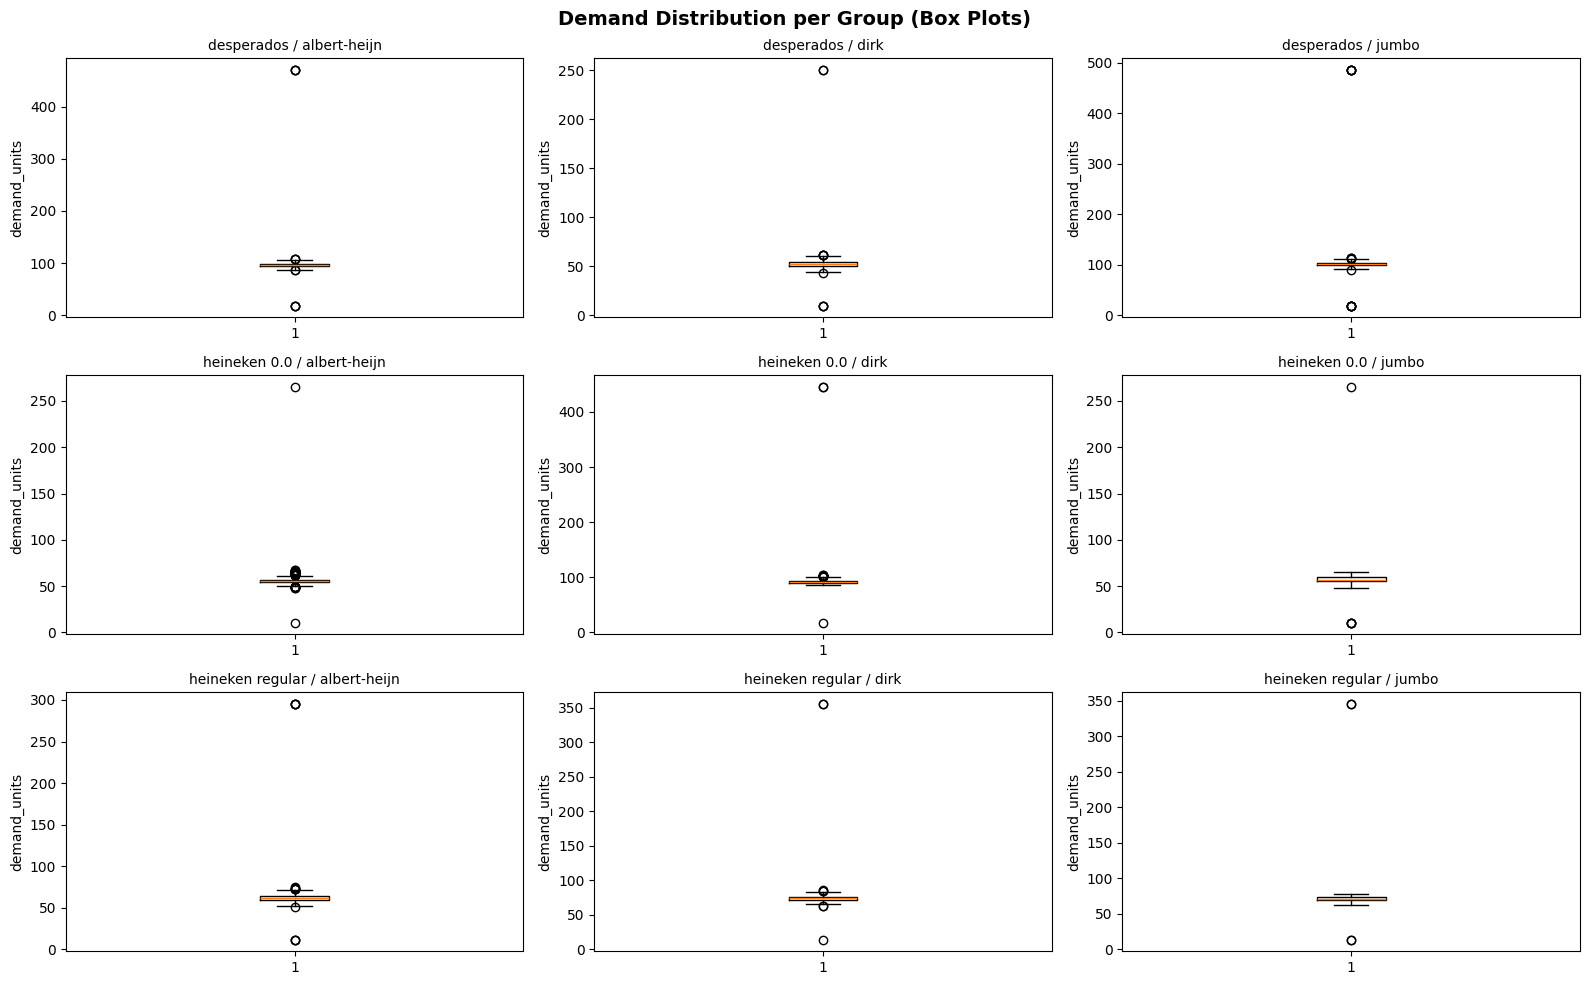


Outlier summary (values above 1.5×IQR upper fence):


,sku,supermarket,n_outliers,max_value,upper_fence,median
0,desperados,albert-heijn,6,470.0,106.5,97.0
1,desperados,dirk,6,250.0,60.0,52.0
2,desperados,jumbo,9,485.0,111.5,101.0
3,heineken 0.0,albert-heijn,33,265.0,61.5,55.0
4,heineken 0.0,dirk,14,445.0,100.0,92.0
5,heineken 0.0,jumbo,1,265.0,67.5,57.0
6,heineken regular,albert-heijn,10,295.0,71.5,62.0
7,heineken regular,dirk,5,355.0,83.5,74.0
8,heineken regular,jumbo,2,345.0,79.0,71.0


In [7]:
# Outlier detection
fig, axes = plt.subplots(3, 3, figsize=(16, 10))

outlier_summary = []
for idx, ((sku, sm), grp) in enumerate(groups):
    ax = axes[idx // 3, idx % 3]
    data = grp["demand"].dropna()
    ax.boxplot(data, vert=True)
    ax.set_title(f"{sku} / {sm}", fontsize=10)
    ax.set_ylabel("demand_units")
    
    # IQR-based outliers
    q1, q3 = data.quantile(0.25), data.quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    n_outliers = (data > upper).sum()
    if n_outliers > 0:
        max_val = data.max()
        outlier_summary.append({"sku": sku, "supermarket": sm, "n_outliers": n_outliers, 
                                "max_value": max_val, "upper_fence": round(upper, 1),
                                "median": data.median()})

fig.suptitle("Demand Distribution per Group (Box Plots)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

if outlier_summary:
    print("\nOutlier summary (values above 1.5×IQR upper fence):")
    display(pd.DataFrame(outlier_summary))

### Data Quality Summary

- **Missing values**: ~11% overall, scattered across all groups as short gaps (1–3 days). This is manageable with interpolation.
- **Outliers**: Several groups have extreme spike values that are exact repeated numbers — likely data artifacts or bulk orders. These should be capped for modelling.
- **Date range**: Complete daily coverage from 2019-01-01 to 2021-12-30 (3 years). No date gaps.

## 2. Imputation Strategy

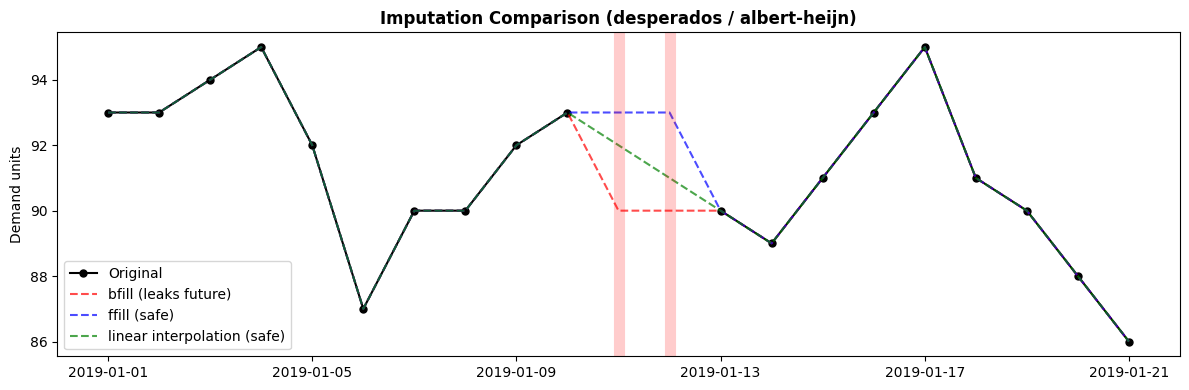

Chosen method: Linear interpolation (no leakage, respects local trend)
Fallback: bfill for leading NaNs, then group mean for any remaining.


In [8]:
# Compare imputation methods on a sample group
sample = demand_raw[(demand_raw["sku"] == "desperados") & (demand_raw["supermarket"] == "albert-heijn")]["demand"].copy()

# Find a region with missing values for visualization
missing_idx = sample[sample.isna()].index
if len(missing_idx) > 0:
    # Pick a window around the first missing value
    center = missing_idx[0]
    window_start = center - pd.Timedelta(days=10)
    window_end = center + pd.Timedelta(days=10)
    window = sample.loc[window_start:window_end]
    
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # Original (with gaps)
    ax.plot(window.index, window, 'ko-', label='Original', markersize=5)
    
    # Bfill (current approach - leaks future data)
    bfilled = sample.bfill().loc[window_start:window_end]
    ax.plot(bfilled.index, bfilled, 'r--', label='bfill (leaks future)', alpha=0.7)
    
    # Ffill
    ffilled = sample.ffill().loc[window_start:window_end]
    ax.plot(ffilled.index, ffilled, 'b--', label='ffill (safe)', alpha=0.7)
    
    # Linear interpolation
    interp = sample.interpolate(method='linear').loc[window_start:window_end]
    ax.plot(interp.index, interp, 'g--', label='linear interpolation (safe)', alpha=0.7)
    
    # Highlight missing positions
    for m in missing_idx:
        if window_start <= m <= window_end:
            ax.axvline(m, color='red', alpha=0.2, linewidth=8)
    
    ax.set_title("Imputation Comparison (desperados / albert-heijn)", fontweight="bold")
    ax.legend()
    ax.set_ylabel("Demand units")
    plt.tight_layout()
    plt.show()

print("Chosen method: Linear interpolation (no leakage, respects local trend)")
print("Fallback: bfill for leading NaNs, then group mean for any remaining.")

In [9]:
# Apply safe imputation
def clean_safe(ts: pd.Series) -> pd.Series:
    """Interpolate missing values without leaking future data."""
    return ts.interpolate(method="linear").bfill().fillna(ts.mean())

demand = demand_raw.copy()
demand["demand"] = demand.groupby(["sku", "supermarket"])["demand"].transform(clean_safe)
assert demand["demand"].isna().sum() == 0, "Still have missing values!"
print(f"Imputation complete. Missing values remaining: {demand['demand'].isna().sum()}")

Imputation complete. Missing values remaining: 0


In [10]:
# Extend promotions to 7 days and merge
promo_ext = extend_promotions_days(promotions, n_days=7)
demand = merge(demand, promo_ext)
print(f"Merged data shape: {demand.shape}")
print(f"Promotion days: {demand['promotion'].sum()} / {len(demand)} ({demand['promotion'].mean()*100:.1f}%)")

# Show promotion coverage per group
promo_coverage = demand.groupby(["sku", "supermarket"])["promotion"].sum().reset_index()
promo_coverage.columns = ["sku", "supermarket", "promo_days"]
print("\nPromotion days per group:")
display(promo_coverage)

Merged data shape: (9855, 5)
Promotion days: 105 / 9855 (1.1%)

Promotion days per group:


,sku,supermarket,promo_days
0,desperados,albert-heijn,0
1,desperados,dirk,7
2,desperados,jumbo,28
3,heineken 0.0,albert-heijn,28
4,heineken 0.0,dirk,14
5,heineken 0.0,jumbo,7
6,heineken regular,albert-heijn,14
7,heineken regular,dirk,7
8,heineken regular,jumbo,0


## 3. Time Series Patterns

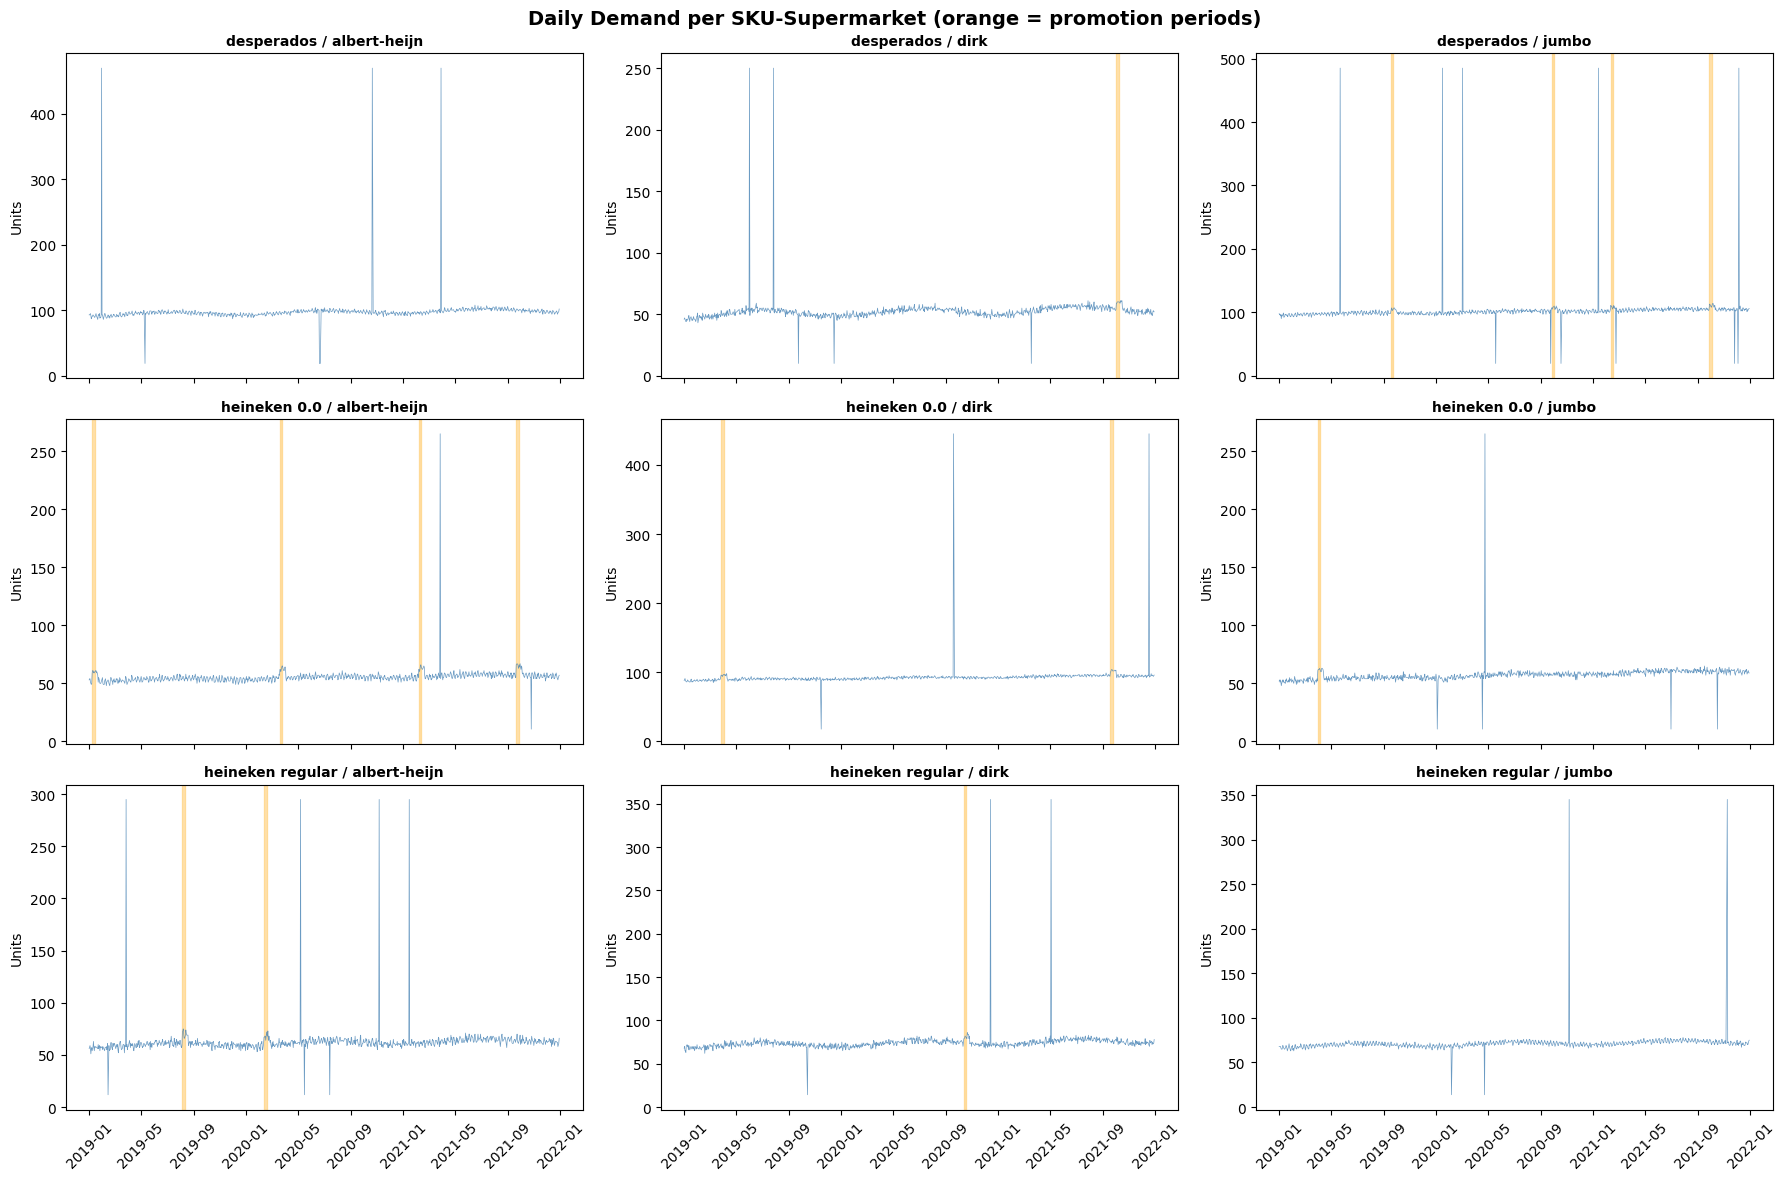

In [11]:
# Daily demand time series per group
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True)

for idx, ((sku, sm), grp) in enumerate(demand.groupby(["sku", "supermarket"])):
    ax = axes[idx // 3, idx % 3]
    ax.plot(grp.index, grp["demand"], linewidth=0.5, alpha=0.8, color="steelblue")
    
    # Mark promotion periods
    promo_mask = grp["promotion"] == True
    if promo_mask.any():
        for start, end in zip(
            grp[promo_mask].index[grp[promo_mask].index.to_series().diff().dt.days.fillna(10) > 1],
            grp[promo_mask].index[grp[promo_mask].index.to_series().diff(-1).dt.days.fillna(-10) < -1]
        ):
            ax.axvspan(start, end, alpha=0.3, color="orange", label="Promo" if start == grp[promo_mask].index[0] else "")
    
    ax.set_title(f"{sku} / {sm}", fontsize=10, fontweight="bold")
    ax.set_ylabel("Units")
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("Daily Demand per SKU-Supermarket (orange = promotion periods)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [12]:
# Aggregate to weekly for pattern analysis (matches modelling granularity)
weekly = aggregate_to_weekly(demand)
print(f"Weekly data: {weekly.shape[0]} rows, {weekly.groupby(['sku','supermarket']).ngroups} groups")
print(f"Weeks per group: ~{weekly.groupby(['sku','supermarket']).size().mean():.0f}")
display(weekly.head())

Weekly data: 1413 rows, 9 groups
Weeks per group: ~157


,sku,supermarket,demand,promotion
date,,,,
2019-01-06,desperados,albert-heijn,554.0,False
2019-01-13,desperados,albert-heijn,638.0,False
2019-01-20,desperados,albert-heijn,637.0,False
2019-01-27,desperados,albert-heijn,636.0,False
2019-02-03,desperados,albert-heijn,1013.0,False


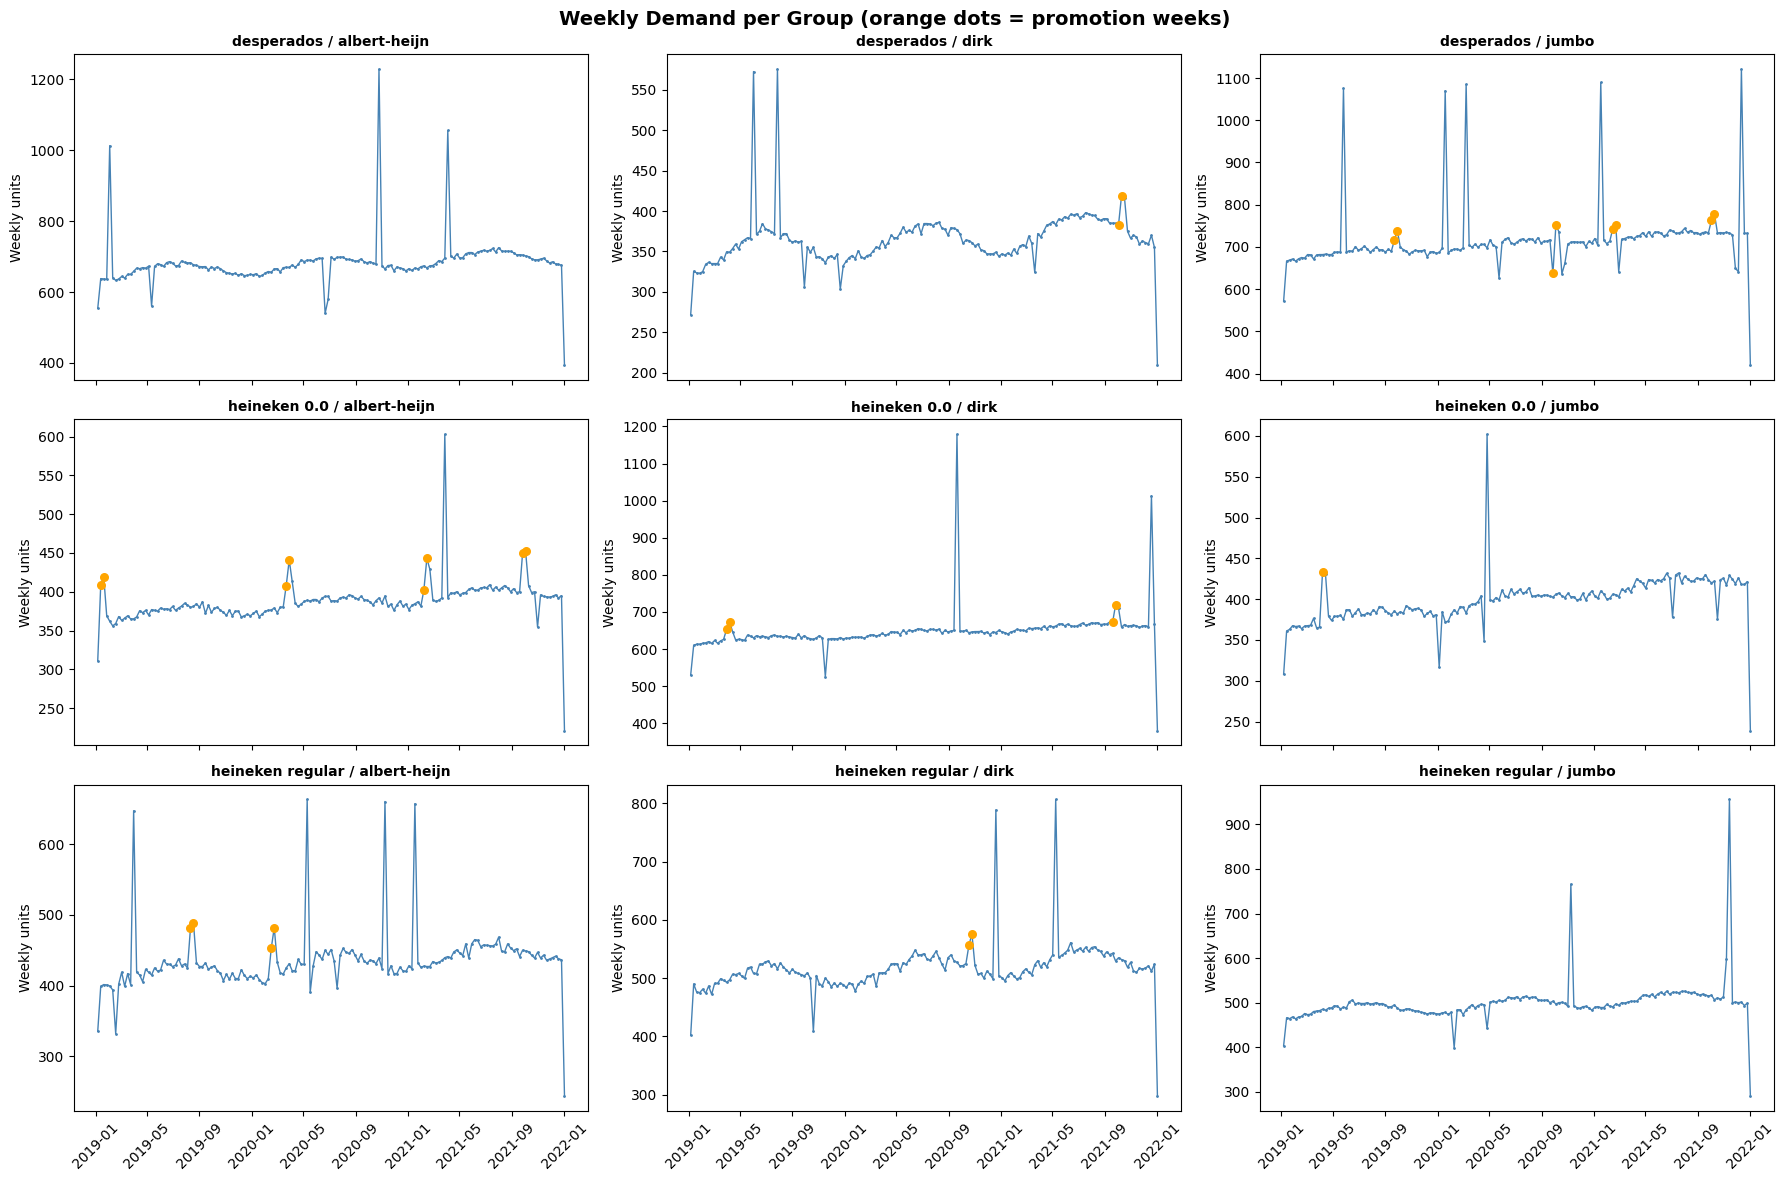

In [13]:
# Weekly demand time series
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True)

for idx, ((sku, sm), grp) in enumerate(weekly.groupby(["sku", "supermarket"])):
    ax = axes[idx // 3, idx % 3]
    ax.plot(grp.index, grp["demand"], linewidth=1, color="steelblue", marker=".", markersize=2)
    
    # Mark promotion weeks
    promo_weeks = grp[grp["promotion"] > 0]
    if len(promo_weeks) > 0:
        ax.scatter(promo_weeks.index, promo_weeks["demand"], color="orange", 
                   zorder=5, s=30, label="Promo week")
    
    ax.set_title(f"{sku} / {sm}", fontsize=10, fontweight="bold")
    ax.set_ylabel("Weekly units")
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("Weekly Demand per Group (orange dots = promotion weeks)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

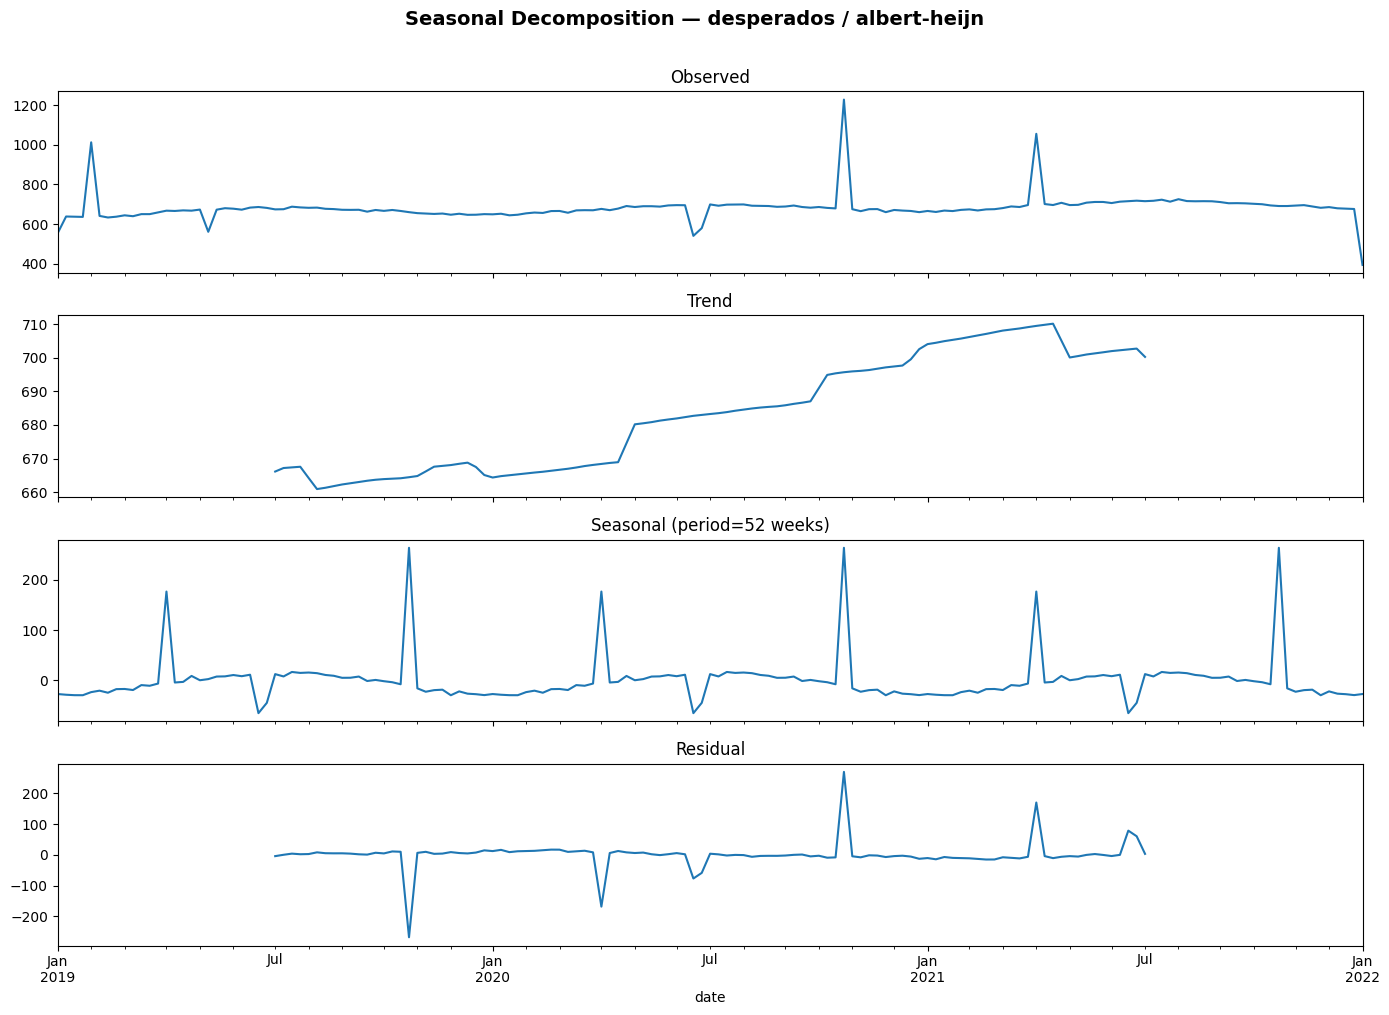

In [14]:
# Seasonal decomposition (representative group)
sample_grp = weekly[(weekly["sku"] == "desperados") & (weekly["supermarket"] == "albert-heijn")]["demand"]
sample_grp = sample_grp.asfreq("W", method="ffill")

decomposition = seasonal_decompose(sample_grp, model="additive", period=52)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
decomposition.observed.plot(ax=axes[0], title="Observed")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonal (period=52 weeks)")
decomposition.resid.plot(ax=axes[3], title="Residual")

fig.suptitle("Seasonal Decomposition — desperados / albert-heijn", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

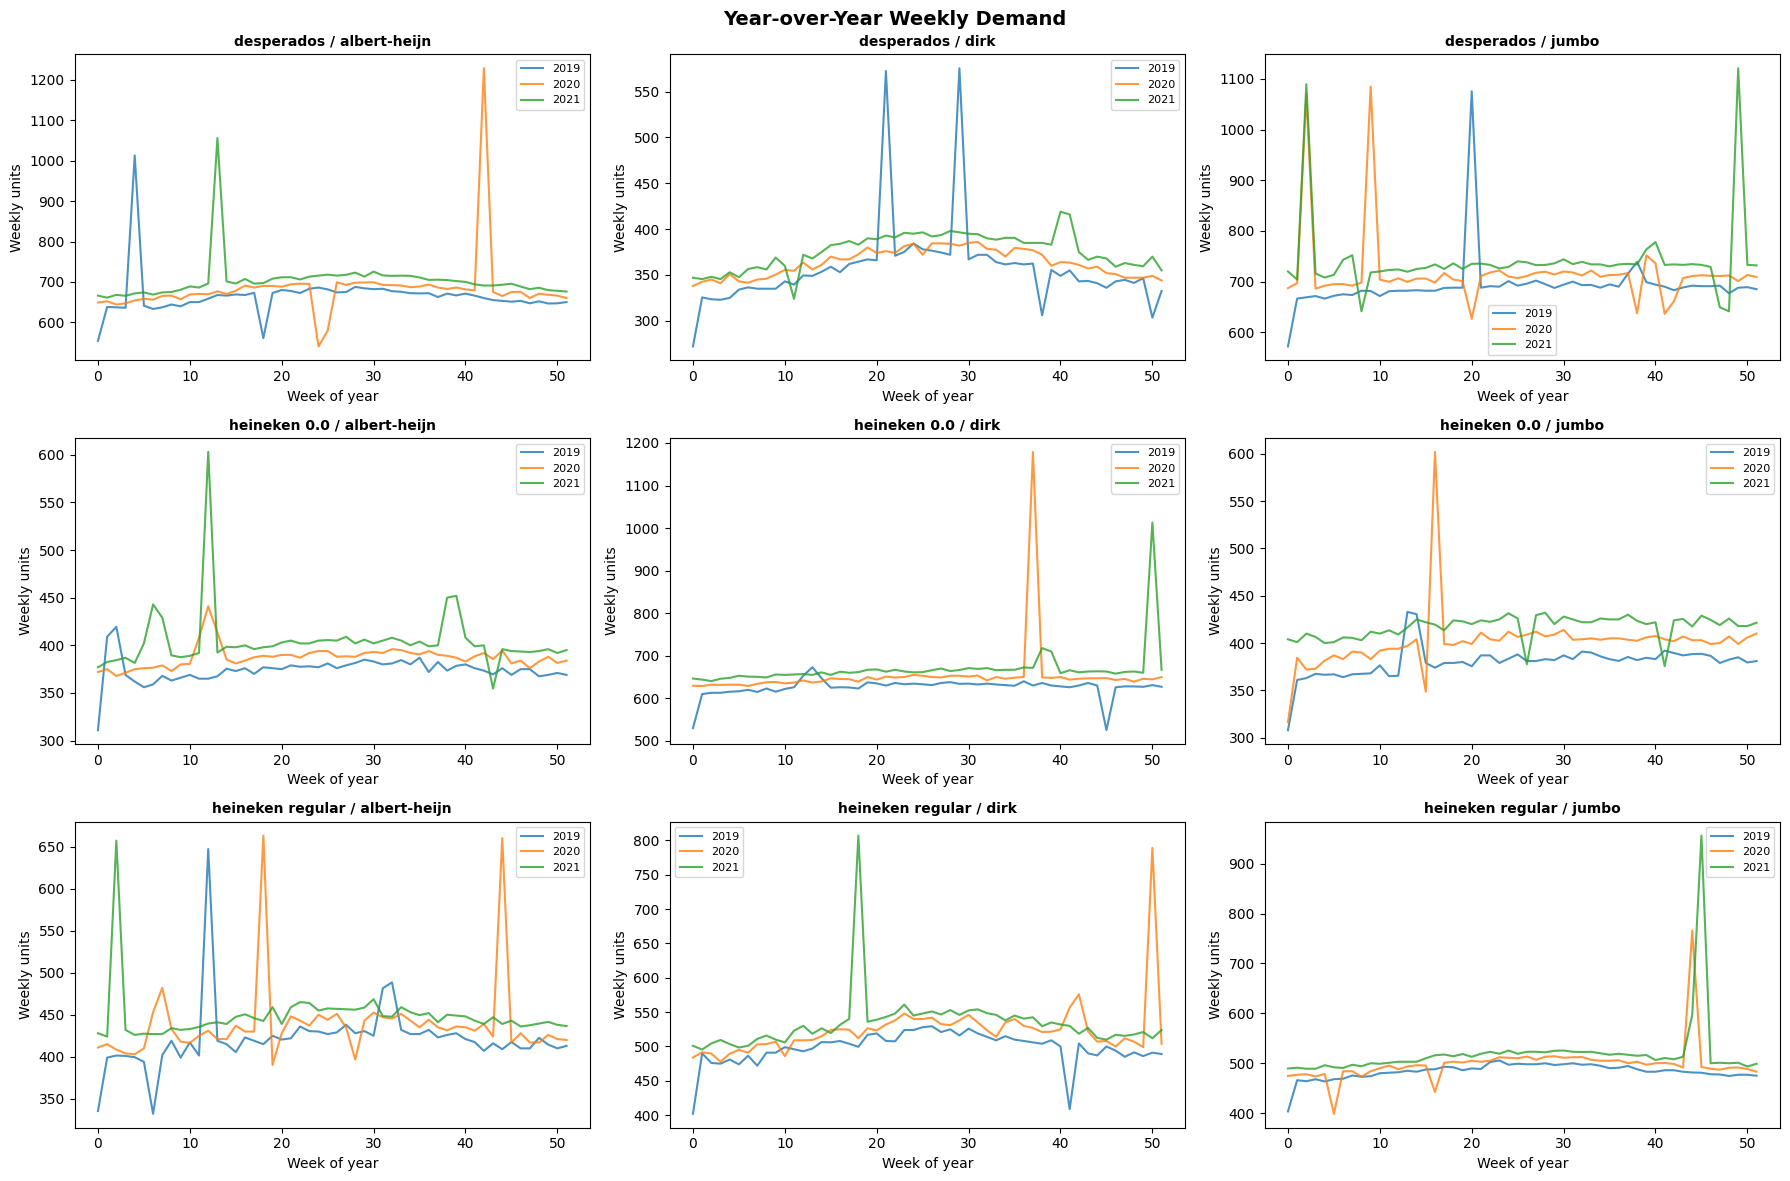

In [15]:
# Year-over-year comparison
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for idx, ((sku, sm), grp) in enumerate(weekly.groupby(["sku", "supermarket"])):
    ax = axes[idx // 3, idx % 3]
    for year in [2019, 2020, 2021]:
        year_data = grp[grp.index.year == year]
        ax.plot(range(len(year_data)), year_data["demand"].values, label=str(year), alpha=0.8)
    ax.set_title(f"{sku} / {sm}", fontsize=10, fontweight="bold")
    ax.set_xlabel("Week of year")
    ax.set_ylabel("Weekly units")
    ax.legend(fontsize=8)

fig.suptitle("Year-over-Year Weekly Demand", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [16]:
# Trend analysis: yearly averages
yearly_avg = demand.groupby(["sku", "supermarket", demand.index.year])["demand"].mean().unstack()
yearly_avg.columns = [f"avg_{y}" for y in yearly_avg.columns]
print("Average daily demand by year:")
display(yearly_avg.round(1))

Average daily demand by year:


avg_2019  avg_2020  avg_2021
sku              supermarket                               
desperados       albert-heijn      95.3      97.6     100.4
                 dirk              51.2      51.9      53.8
                 jumbo             99.3     102.6     105.9
heineken 0.0     albert-heijn      53.6      55.4      57.7
                 dirk              89.7      93.5      95.6
                 jumbo             54.4      57.3      59.6
heineken regular albert-heijn      60.4      62.7      64.1
                 dirk              71.4      74.8      76.2
                 jumbo             69.3      71.3      74.2

## 4. Autocorrelation Analysis

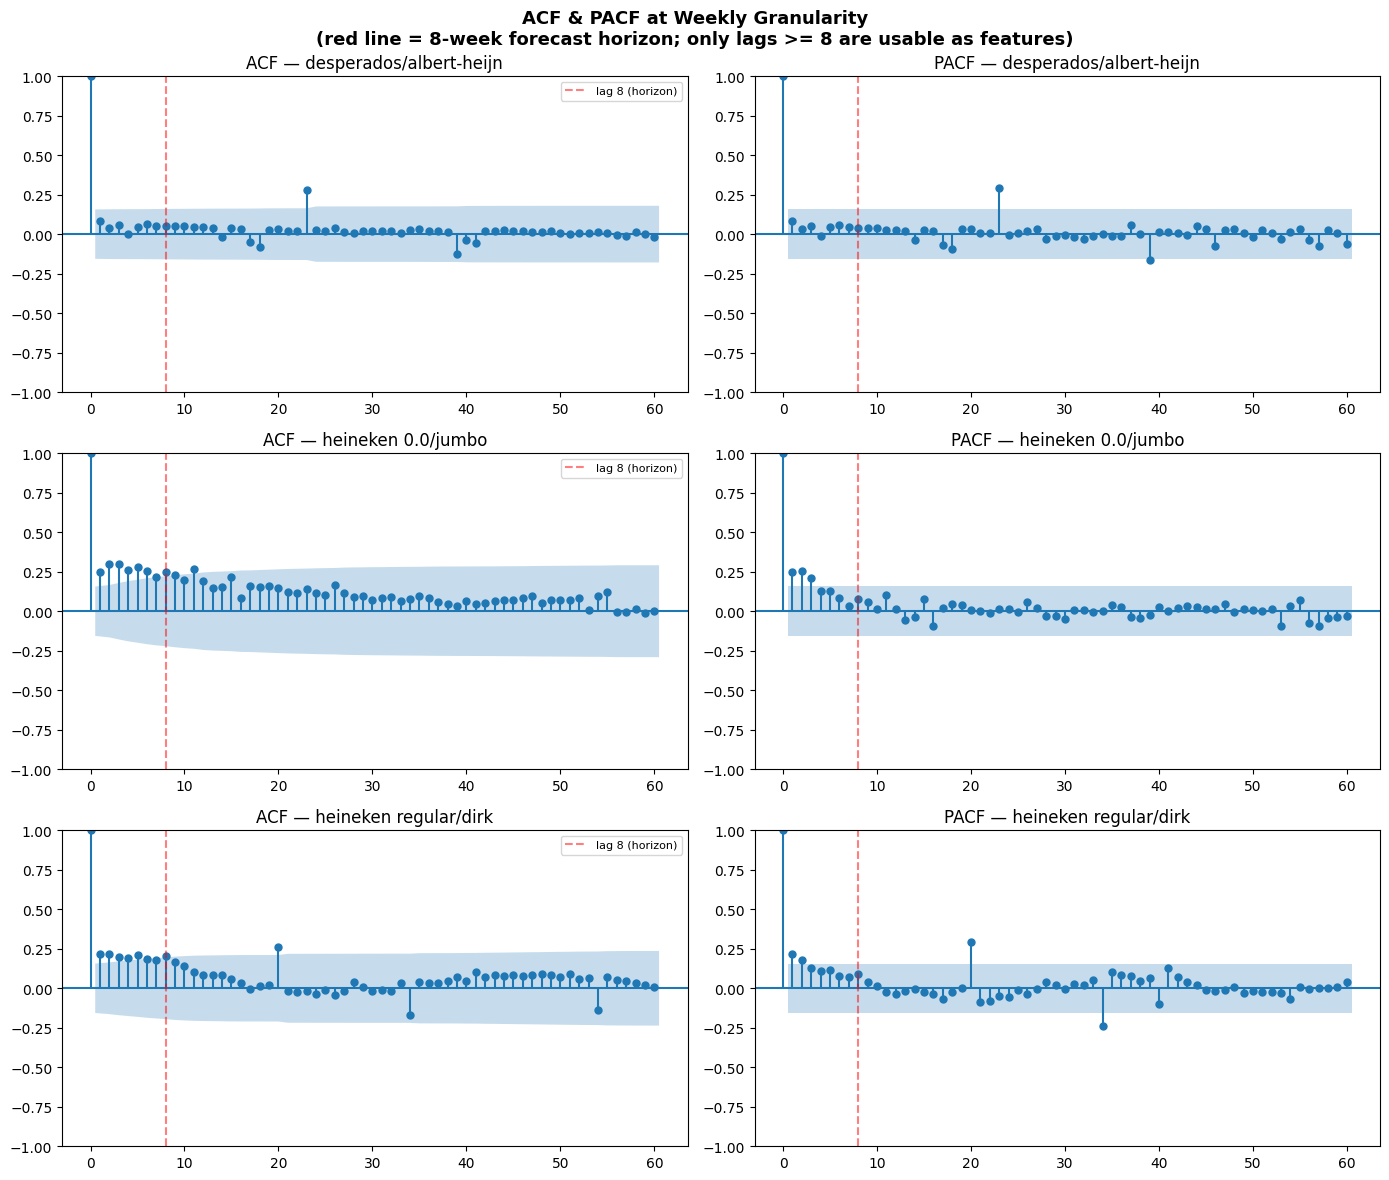

In [17]:
# ACF and PACF plots for weekly demand
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Pick 3 representative groups
representative = [
    ("desperados", "albert-heijn"),
    ("heineken 0.0", "jumbo"),
    ("heineken regular", "dirk")
]

for i, (sku, sm) in enumerate(representative):
    grp = weekly[(weekly["sku"] == sku) & (weekly["supermarket"] == sm)]["demand"]
    grp = grp.asfreq("W", method="ffill")
    
    plot_acf(grp, ax=axes[i, 0], lags=60, title=f"ACF — {sku}/{sm}")
    plot_pacf(grp, ax=axes[i, 1], lags=60, title=f"PACF — {sku}/{sm}")
    
    # Highlight the 8-week lag (forecast horizon)
    axes[i, 0].axvline(x=8, color='red', linestyle='--', alpha=0.5, label='lag 8 (horizon)')
    axes[i, 1].axvline(x=8, color='red', linestyle='--', alpha=0.5, label='lag 8 (horizon)')
    axes[i, 0].legend(fontsize=8)

fig.suptitle("ACF & PACF at Weekly Granularity\n(red line = 8-week forecast horizon; only lags >= 8 are usable as features)",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

In [18]:
# Stationarity tests (ADF)
print("Augmented Dickey-Fuller test (weekly demand):")
print(f"{'SKU':<20} {'Supermarket':<15} {'ADF Stat':>10} {'p-value':>10} {'Stationary?':>12}")
print("-" * 70)

for (sku, sm), grp in weekly.groupby(["sku", "supermarket"]):
    series = grp["demand"].dropna()
    if len(series) < 20:
        continue
    result = adfuller(series, autolag="AIC")
    stationary = "Yes" if result[1] < 0.05 else "No"
    print(f"{sku:<20} {sm:<15} {result[0]:>10.3f} {result[1]:>10.4f} {stationary:>12}")

Augmented Dickey-Fuller test (weekly demand):
SKU                  Supermarket       ADF Stat    p-value  Stationary?
----------------------------------------------------------------------
desperados           albert-heijn       -10.810     0.0000          Yes
desperados           dirk                -3.073     0.0286          Yes
desperados           jumbo               -8.028     0.0000          Yes
heineken 0.0         albert-heijn        -2.273     0.1808           No
heineken 0.0         dirk                -8.745     0.0000          Yes
heineken 0.0         jumbo               -2.852     0.0512           No
heineken regular     albert-heijn       -11.268     0.0000          Yes
heineken regular     dirk                -5.645     0.0000          Yes
heineken regular     jumbo               -9.278     0.0000          Yes


## 5. Promotion Effect Analysis

In [19]:
# Promotion effect: compare weekly demand during promo vs non-promo weeks
promo_effect = []
for (sku, sm), grp in weekly.groupby(["sku", "supermarket"]):
    promo_weeks = grp[grp["promotion"] > 0]["demand"]
    non_promo_weeks = grp[grp["promotion"] == 0]["demand"]
    
    if len(promo_weeks) > 0:
        uplift = (promo_weeks.mean() - non_promo_weeks.mean()) / non_promo_weeks.mean() * 100
        promo_effect.append({
            "sku": sku, "supermarket": sm,
            "promo_weeks": len(promo_weeks),
            "avg_demand_promo": round(promo_weeks.mean(), 1),
            "avg_demand_normal": round(non_promo_weeks.mean(), 1),
            "uplift_%": round(uplift, 1)
        })
    else:
        promo_effect.append({
            "sku": sku, "supermarket": sm,
            "promo_weeks": 0,
            "avg_demand_promo": None,
            "avg_demand_normal": round(grp["demand"].mean(), 1),
            "uplift_%": None
        })

promo_df = pd.DataFrame(promo_effect)
print("Promotion effect per group:")
display(promo_df)

Promotion effect per group:


,sku,supermarket,promo_weeks,avg_demand_promo,avg_demand_normal,uplift_%
0,desperados,albert-heijn,0,NaN,681.9,NaN
1,desperados,dirk,2,401.0,364.2,10.1
2,desperados,jumbo,8,735.0,714.4,2.9
3,heineken 0.0,albert-heijn,8,428.1,385.3,11.1
4,heineken 0.0,dirk,4,678.9,647.2,4.9
5,heineken 0.0,jumbo,1,433.0,398.3,8.7
6,heineken regular,albert-heijn,4,476.2,434.1,9.7
7,heineken regular,dirk,2,566.2,516.5,9.6
8,heineken regular,jumbo,0,NaN,499.3,NaN


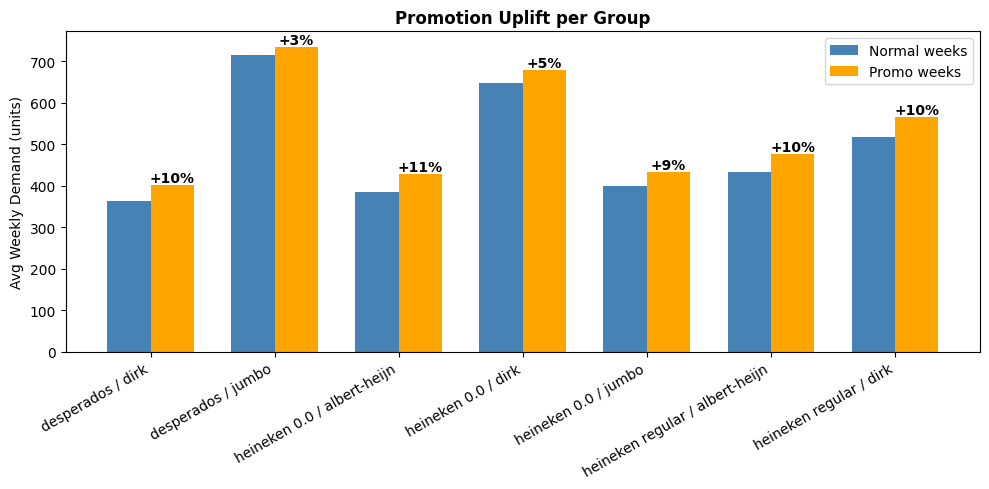


Note: Only 29 promotion weeks across all groups.
desperados/albert-heijn and heineken regular/jumbo have ZERO promotions.


In [20]:
# Visualize promotion uplift
promo_viz = promo_df[promo_df["promo_weeks"] > 0].copy()
promo_viz["label"] = promo_viz["sku"] + " / " + promo_viz["supermarket"]

fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(promo_viz))
width = 0.35

ax.bar([i - width/2 for i in x], promo_viz["avg_demand_normal"], width, label="Normal weeks", color="steelblue")
ax.bar([i + width/2 for i in x], promo_viz["avg_demand_promo"], width, label="Promo weeks", color="orange")

# Add uplift labels
for i, row in enumerate(promo_viz.itertuples()):
    ax.annotate(f"+{row._6:.0f}%", xy=(i + width/2, row.avg_demand_promo),
                ha="center", va="bottom", fontweight="bold", fontsize=10)

ax.set_xticks(list(x))
ax.set_xticklabels(promo_viz["label"], rotation=30, ha="right")
ax.set_ylabel("Avg Weekly Demand (units)")
ax.set_title("Promotion Uplift per Group", fontweight="bold")
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nNote: Only {promo_viz['promo_weeks'].sum()} promotion weeks across all groups.")
print("desperados/albert-heijn and heineken regular/jumbo have ZERO promotions.")

## 6. Feature Engineering Ideas for 8-Week-Ahead Forecast

| Feature Category | Features | Rationale | Leakage Risk |
|:----------------|:---------|:----------|:-------------|
| **Calendar** | `week_of_year`, `month`, `quarter`, `is_december` | Capture seasonal patterns | None |
| **Lag features** | `demand_lag_8`, `lag_9`, `lag_10`, `lag_12` | Recent history respecting 8-week gap | Must use lag >= 8 |
| **Rolling stats** | `rolling_mean_4w` (at lag 8), `rolling_std_4w` (at lag 8) | Smoothed trend signal | Compute on t-8 and earlier |
| **Year-over-year** | `demand_lag_52` | Annual cycle signal (ACF shows significance) | Must exist in data |
| **Promotion** | `promo_this_week` | Planned events are known in advance | None (promos are pre-planned) |
| **Trend** | `week_number` (linear counter) | Mild upward drift observed across groups | None |
| **Group identity** | `sku_encoded`, `supermarket_encoded` | Different demand levels per group | None (for global model) |

## 7. Key Takeaways for Modelling

1. **Data quality is manageable**: ~11% missing values as short scattered gaps. Linear interpolation fills them without leaking future data.

2. **Mild trend, weak seasonality**: Most groups show a slight upward trend year-over-year. Seasonal patterns are present but not dramatic — no strong summer/winter effect.

3. **Outlier spikes**: Each group has a handful of exact repeated high values (e.g., 485 for desperados/jumbo). These are likely data artifacts and should be capped at the 99th percentile for modelling.

4. **8-week horizon constrains features**: Autocorrelation is significant at short lags (1–4 weeks), but these cannot be used for an 8-week-ahead forecast. Lag features must start at lag 8 or higher. Lag-52 (year-over-year) is also informative.

5. **Promotions are sparse but impactful**: Only 7 of 9 groups have promotions (total 29 promo weeks). Where present, demand uplift ranges from modest to substantial. Promotions are *planned in advance*, so the promo flag for the target week is known at prediction time.

6. **Small data favours simple models**: ~157 weeks per group = ~100 usable training rows after lag features. Ridge regression, Exponential Smoothing, or a small Gradient Boosting model are appropriate. Deep learning or complex ensembles would overfit.

7. **Weekly aggregation is the right granularity**: Matches the business target (weekly demand), reduces daily noise, and aligns with promotion windows (7-day promos map to ~1 week).